# Create a extra large FGS image for testing on the FGSES 

**NOTE**: This notebook must be run on a machine that has access to central store if you want to add extra stars in the background

Make an XL image for FGSES using a Full Frame, CDS, or Seed FGS image. This notebook will padd a FGS fits file from 2048 x 2048 out to a image between 4097x4097 and 4636x4636 to be compatible with the FGSES. This notebook will also add extra (phased) PSFs to the added padded area.

Dependencies:
- astropy
- matplotlib
- numpy
- jwst_magic (private GitHub repository)

### WARNING
This notebook requires inputs from the user. Please pay attention to which cells will need to be changed based on the user's needs. 

In [2]:
import os

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

from jwst_magic.utils import utils
from jwst_magic.fsw_file_writer import write_files

%matplotlib inline

Using backend:  Qt5Agg
Your MAGIC package is up to date
Your FGS COUNTRATE package is up to date


In [12]:
#####################################################
# USER NEEDS TO CHANGE THESE WITH EACH NEW DATA SET #
#####################################################
# Set input filenames
in_dir = '/users/holfeltz/data/'
infile = os.path.join(in_dir, 'test_guideScene.fits')

In [13]:
#####################################################
# USER NEEDS TO CHANGE THESE WITH EACH NEW DATA SET #
#####################################################
# Set output filenames
out_dir = '/users/holfeltz/notebooks/'
filename = 'test_shifted_XL'
fits_out = os.path.join(out_dir, f'{filename}.fits')
dat_out = os.path.join(out_dir, f'{filename}.dat')

In [14]:
#####################################################
# USER NEEDS TO CHANGE THESE WITH EACH NEW DATA SET #
#####################################################
# Tell us what kind of image this is. 
# The acceptable types are: 'cds', 'ff', 'seed'
#    'cds' : The ID CDS image from MAGIC (in 'stsci_'), we expect this to be a cube in units of counts
#    'ff'  : The Full Frame ID image from MAGIC (in 'stsci_'), we expect this to be a single frame in units of counts
#    'seed': The image in 'FGS_imgs' from MAGIC, this is in units of ADU/s and is lacking any bias information
# Note that the 'seed' image will not account for saturation correctly since we are not calculating it based on the
# different reads

image_type = 'ff'


In [15]:
################################################
# USER MAY CHANGE THESE WITH EACH NEW DATA SET #
################################################
nstars = 250
locount = 15000
hicount = 10000000


In [16]:
#################################################################
# USER NEEDS TO CHANGE X0 & Y0 DEPENDING ON THE INPUT IMAGE TYPE#
#################################################################
# cds images are from guiding_config_?/stsci_shifted/*IDcds.fits
# ff  images are from guiding_config_?/stsci_shifted/*IDff.fits
# seed images are from anywhere         
# shifted cds & ff images have the GS at (1024,1024) 
# seed images need to be shifted to put the GS at the center of the XL image

small_y0 = 901   # DS9 x
small_x0 = 1101  # DS9 y


In [17]:
# PSF locations
psf_template_loc = '/user/holfeltz/simdata/webb_templates/'
opd = 'OPD4'

In [18]:
# Set up variables & indexing stuff
psfx, psfy = 101, 101

half_psf = psfx//2 + 1

small_image_size = 2048
big_image_size = 4200 # Size must be between 4097x4097 and 4636x4636 (inclusively)

big_x0 = big_image_size//2
big_y0 = big_x0

inset_x_lo = big_x0 - small_x0
inset_x_hi = inset_x_lo + small_image_size
inset_y_lo = big_y0 - small_y0
inset_y_hi = inset_y_lo + small_image_size

In [19]:
# Read input data and header
data, hdr = fits.getdata(infile, ext=0, header=True)
print(f"Data minimum: {np.min(data)}, maximum:{np.max(data)}")

# Make sure that we are only working with one frame in units of counts
if image_type.lower() == 'cds':
    data = data[0]
    x0, y0 = 1024, 1024

elif image_type.lower() == 'ff':
    data = data
    x0, y0 = 1024, 1024

elif image_type.lower() == 'seed': 
    data = data*0.3406 # Convert to counts
    data = utils.correct_image(data, upper_threshold=65535, upper_limit=65535)
    x0, y0 = gs_x, gs_y

else:
    print(f"We don't know how to deal with {image_type} data. Please use only 'cds', 'ff, or 'seed'.")


Data minimum: -121.0, maximum:32647.0


In [20]:
# Initialize output img
obs = np.zeros([big_image_size, big_image_size])   # big output files
obs[inset_x_lo : inset_x_hi, inset_y_lo : inset_y_hi] = data  # small insert/starting file

In [21]:
# Set up dummy arrays with pixel values that equal their x & y coords
x = np.zeros([big_image_size,big_image_size])
y = x
for i in range(big_image_size):
    x[:,i] = i
y = np.rot90(x)
y = np.flipud(y)

# divide up padded area into left, right, top, & bottom regions
# get (ix,iy) indices for where in the 2400x2400 image these pixel are located
pad_img = np.zeros([big_image_size,big_image_size])
pad_img[half_psf : inset_x_lo, half_psf : big_image_size - half_psf] = 1                                      # left
pad_img[inset_x_hi + half_psf : big_image_size - half_psf, half_psf : big_image_size - half_psf] = 1          # right
pad_img[inset_x_lo + half_psf : inset_x_hi - half_psf, inset_y_hi + half_psf : big_image_size - half_psf] = 1 # top
pad_img[inset_x_lo + half_psf : inset_x_hi - half_psf, half_psf : inset_y_lo] = 1                             # bottom
ixpad = np.where(pad_img == 1)
ss = np.shape(ixpad)

# get x & y coords in padded region for each requested pad-star
i = np.random.randint(0,ss[1],size=nstars)
x_rp = []
y_rp = []
for k in range(nstars):
    x_rp.append(ixpad[0][i[k]])
    y_rp.append(ixpad[1][i[k]])

# get counts for each requsted pad-star
adu = np.random.randint(locount,hicount,nstars)

# PSF identifier for finding the PSF to use
ipsf = np.random.randint(100,999,nstars)
spsf = ["" for k in range(nstars)]
spsf = str(ipsf).zfill(3)


In [23]:
# Accumulate all stars in FOV at real pixel positions (postage stamps)
try:
    for x, y, counts, psf in zip(x_rp, y_rp, adu, ipsf):
        tmp = np.zeros_like(obs)
        x1 = x - psfx//2
        x2 = x + psfx//2 + 1
        y1 = y - psfy//2
        y2 = y + psfy//2 + 1

        # use psf templates
        psftemp = os.path.join(psf_template_loc, f'M0V_{opd}_{psf}.fits')
        psfii = fits.getdata(psftemp)
        psfdat = counts * psfii / psfii.sum() # normalize psf
        tmp[x1:x2, y1:y2] = psfdat
        obs += tmp  # add psf to output img
        
except FileNotFoundError:
    print('You are probably not connected to central store. If you ', 
          'want to include extra background stars, connect to central store and then run this cell again')

You are probably not connected to central store. If you  want to include extra background stars, connect to central store and then run this cell again


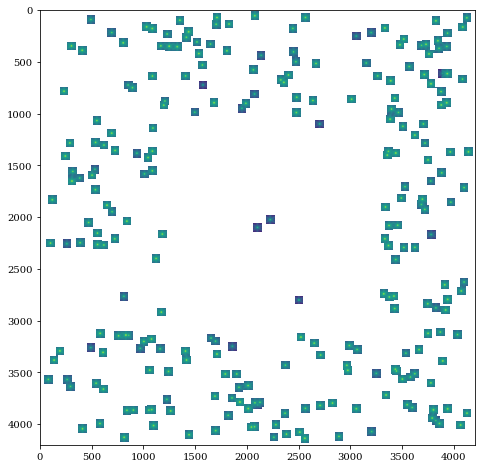

In [11]:
# Plot it out!
plt.figure(figsize=(10, 8))
plt.imshow(obs, norm=LogNorm())
plt.show()

In [12]:
# Write out fits file
print('writing fits file')

utils.write_fits(fits_out, obs, header=hdr)

# uint16(any value greater than 65,535) wraps instead of truncates
# so we need to truncate the saturated values before we uint
obs = utils.correct_image(obs,upper_threshold=65535, upper_limit=65535)

# Write out dat file
for_dat = np.uint16(obs)
flat = for_dat.flatten()
fmt = '{:04X} '
with open(dat_out, 'w') as file_out:
    for dat in flat.astype(np.uint16):
        file_out.write(fmt.format(dat))

print('done')

writing fits file
Successfully wrote: /users/holfeltz/notebooks/test_shifted_XL.fits
done


####  About this notebook:
Author: S. Holfeltz

Last updated: 2 November, 2021